# axial MRI brain tumor detection

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

# Dataset 

In [2]:
print(f"axial_train: {len(os.listdir('axial_MRI/train')) - 1}")
print(f"axial_val: {len(os.listdir('axial_MRI/valid')) - 1}")
print(f"axial_test: {len(os.listdir('axial_MRI/test')) - 1}")

axial_train: 253
axial_val: 79
axial_test: 39


In [3]:
bbox = pd.read_csv('axial_MRI/train/_annotations.csv')

bbox.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,00254_83_jpg.rf.dc8444a939bfda955ec3a0ef668b5c...,192,256,positive,50,105,77,143
1,00305_113_jpg.rf.da8b7d0769c01e94571b568186f33...,256,256,positive,150,91,167,106
2,00097_80_jpg.rf.e31f89dee132f5da82d5e3c3fc0125...,256,256,negative,160,151,192,186
3,00099_154_jpg.rf.d9eb261c8c610b762f46f1e6f7cfc...,256,256,negative,90,187,107,205
4,00240_134_jpg.rf.dacd6bdae9ee803c1eed41507c352...,192,256,positive,85,97,106,126


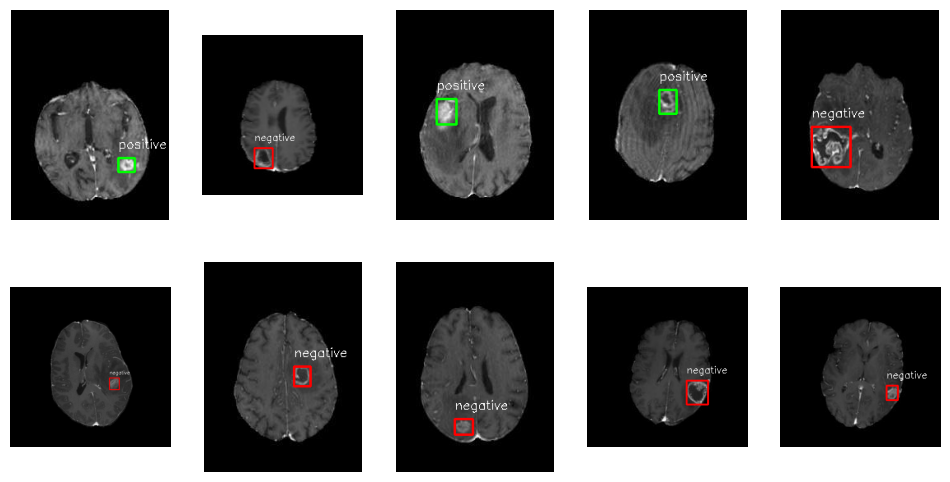

In [4]:
import random

figure = plt.figure(figsize=(12, 6)) 

row, col = 2, 5

r = random.randint(1, len(bbox))

for i in range(10):
    r = random.randint(1, len(bbox))
    value = bbox.values[r]
    img_name = value[0]
    color = (0, 255, 0) if value[3] == 'positive' else (255, 0, 0)
    txt = 'positive' if value[3] == 'positive' else 'negative'
    box = value[4:].astype('int')
    img = cv2.imread(f'axial_MRI/train/{img_name}')
    pt1 = box[0], box[1]
    pt2 = box[2], box[3]
    cv2.rectangle(img, pt1, pt2, color, 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    text_size, _ = cv2.getTextSize(txt, font, font_scale, thickness)
    x, y = pt1
    text_x = x
    text_y = y - text_size[1]
    cv2.putText(img, txt, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)
    figure.add_subplot(row, col, i+1)
    plt.axis("off")
    plt.imshow(img)

# Selective Search

num_regional proposal: 86


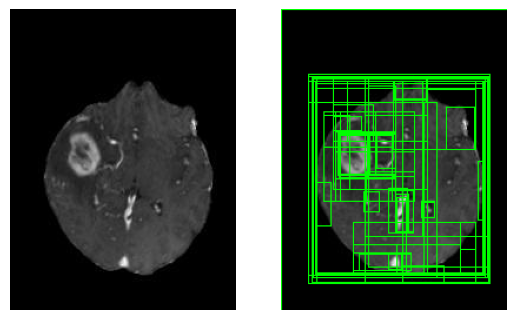

In [5]:
img = cv2.imread(f'axial_MRI/train/{bbox.values[0][0]}')

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
ss.setBaseImage(img) 
ss.switchToSelectiveSearchFast() 
rects = ss.process()

for rect in rects:
    x, y, w, h = rect
    img_out = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_out)
print(f'num_regional proposal: {len(rects)}')

In [6]:
from regional_proposal import selective_search_

cv2.setUseOptimized(True) 
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 

up_threshold = 0.6
down_threshold = 0.3

threshold = (up_threshold, down_threshold)
positive_sample = []
negative_sample = []

for value in bbox.values:
    name = value[0]
    value
    positive = True if value[3] == 'positive' else False
    img = cv2.imread(f'axial_MRI/train/{name}')
    gtbox = bbox[bbox.filename == name].values[0][4:].astype('int')
    gtbb = {
            'x1': gtbox[0],
            'y1': gtbox[1],
            'x2': gtbox[2],
            'y2': gtbox[3]
           }
    pos, neg = selective_search_(ss, img, gtbb, threshold, positive)
    positive_sample += pos
    negative_sample += neg

len(positive_sample), len(negative_sample)

(1311, 25985)

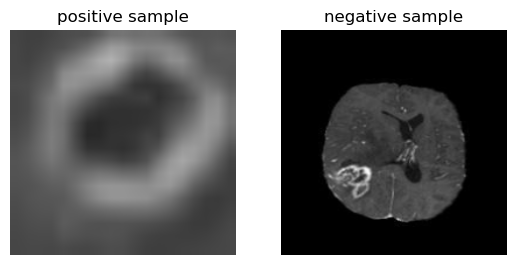

In [8]:
import random

r1 = random.randint(1, len(positive_sample) + 1)
r2 = random.randint(1, len(negative_sample) + 1)

plt.subplot(1, 2, 1)
plt.imshow(positive_sample[r1][0])
plt.axis('off')
plt.title('positive sample')

plt.subplot(1, 2, 2)
plt.imshow(negative_sample[r2][0])
plt.axis('off')
plt.title('negative sample')
plt.show()

In [9]:
ROIs = positive_sample + negative_sample

positive_tumor = []
negative_tumor = []

for img, label in ROIs:
    if label == 1:
        positive_tumor.append(img)
    else:
        negative_tumor.append(img)

len(positive_tumor), len(negative_tumor)

(12077, 15219)

# image augmentation

In [10]:
import imgaug.augmenters as iaa

aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-10, 10)),
    iaa.GammaContrast(gamma=(0.5, 2.0)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
])

In [36]:
augmented_positive_sample = []

for img, label in positive_sample:
    for j in range(20):
        augmented_img = aug_pipeline(image=img)
        augmented_positive_sample.append([augmented_img, label])

len(augmented_positive_sample), len(negative_sample)

(26220, 25985)

# model

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
    ])

class ROIDataset(Dataset): 
    def __init__(self, positive_sample, negative_sample):
        self.datas = np.array(positive_sample + negative_sample)
        self.images = self.datas[:,0]
        self.labels = [1 for i in range(len(positive_sample))] + [0 for i in range(len(negative_sample))]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.transform(self.images[idx])
        label = torch.tentor(self.labels[idx])
        return image, label
    
class TumorDataset(Dataset):
    def __init__(self, positive_tumor, negative_tumor):
        self.images = positive_tumor + negative_tumor
        self.labels = [1 for i in range(len(positive_tumor))] + [0 for i in range(len(negative_tumor))]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.transform(self.images[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

In [38]:
ROIData = ROIDataset(augmented_positive_sample, negative_sample)
TumorData = TumorDataset(positive_tumor, negative_tumor)

torch.save(ROIDataset, 'ROIDataset_train.pt')
torch.save(TumorDataset, 'TumorDataset.pt')

In [ ]:
class ROINet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.sigmoid(x)
        return x

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
dataset = torch.load('ROIDataset_train.pt')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


ROImodel = ROINet()
ROIcriterion = nn.BCELoss()
ROIoptimizer = optim.Adam(ROImodel.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for img, label in enumerate(dataloader, 0):
        image = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = ROImodel(image)
        loss = ROIcriterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")


torch.save(model.state_dict(), "ROImodel.pth")